# Algoritmos Metaheurísticos: Examen 1
Profesor: Dr. Marco Aceves <br>
Alumno: Ing. Enrique Mena Camilo

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython.display import HTML
from matplotlib import animation

sys.path.append('..')

from utils.population import init_octal_population
from utils.casting import oct_array_to_int


## Aptitude utils

In [2]:
def aptitude_function(x1, x2):
    return 100*(x2 - x1**2)**2 + (x1 - 1)**2


def decode_individue(individue: np.ndarray):
    min_domain = -5
    max_domain = 10
    bits = individue.shape[0]
    min_octal = 0
    max_octal = 8**bits - 1
    decoded_individue = oct_array_to_int(individue)
    decoded_individue = (decoded_individue - min_octal) / (max_octal - min_octal)
    decoded_individue = (max_domain - min_domain) * decoded_individue + min_domain

    return decoded_individue


def evaluate_individue(x1: np.ndarray, x2: np.ndarray):
    x1_decoded = decode_individue(x1)
    x2_decoded = decode_individue(x2)
    aptitude = aptitude_function(x1_decoded, x2_decoded)
    
    return aptitude


def evaluate_population(p_x1: np.ndarray, p_x2: np.ndarray, desc: bool = False):
    aptitudes = np.vstack([evaluate_individue(x1, x2) for x1, x2 in zip(p_x1, p_x2)])
    
    direction = -1 if desc else 1
    sorted_indexes = aptitudes[:, -1].argsort()[::direction]
    sorted_px1 = p_x1[sorted_indexes]
    sorted_px2 = p_x2[sorted_indexes]
    sorted_aptitudes = aptitudes[sorted_indexes]
    avg_aptitude = np.mean(sorted_aptitudes)
    best_aptitude = np.min(sorted_aptitudes)

    return sorted_px1, sorted_px2, sorted_aptitudes, avg_aptitude, best_aptitude


## Selection utils

In [3]:
def roulette_selection(aptitudes: np.ndarray):
    total_aptitude = aptitudes.sum()

    couples = []
    couple = []

    for _ in range(aptitudes.shape[0]):
        accumulated = 0
        selection = np.random.uniform(0, total_aptitude)

        for idx, aptitude  in enumerate(aptitudes):
            accumulated += aptitude
            if accumulated >= selection:
                couple.append(idx)
                break
        
        if len(couple) == 2:
            couples.append(couple)
            couple = []

    return np.vstack(couples)


## Crossover utils

In [4]:
def two_point_crossover(population: np.ndarray, parents: np.ndarray):
    childrens = np.empty_like(population)
    for idx, couple in enumerate(parents):
        crossover_point = population.shape[1]//3
        childrens[idx*2, :crossover_point] = population[couple[0], :crossover_point]
        childrens[idx*2, crossover_point:2*crossover_point] = population[couple[1], crossover_point:2*crossover_point]
        childrens[idx*2, 2*crossover_point:] = population[couple[0], 2*crossover_point:]
        childrens[idx*2+1, :crossover_point] = population[couple[1], :crossover_point]
        childrens[idx*2+1, crossover_point:2*crossover_point] = population[couple[0], crossover_point:2*crossover_point]
        childrens[idx*2+1, 2*crossover_point:] = population[couple[1], 2*crossover_point:]

    return childrens


## Mutation utils

In [5]:
def scramble_mutation(individues_x1: np.ndarray, individues_x2: np.ndarray, mr: float = 0.02):
    total_individues = individues_x1.shape[0]
    individue_len = individues_x1.shape[1]
    to_mutate = np.random.choice(total_individues, int(total_individues * mr))

    for idx in to_mutate:
        idx_l, idx_r = sorted(np.random.choice(individue_len, 2))
        idx_r = idx_r if idx_r == individue_len else idx_r + 1
        individues_x1[idx][idx_l:idx_r] = np.random.shuffle(individues_x1[idx][idx_l:idx_r][::-1])
        individues_x2[idx][idx_l:idx_r] = np.random.shuffle(individues_x2[idx][idx_l:idx_r][::-1])

    return individues_x1, individues_x2


## Elitist utils

In [6]:
def genetic_competence(p_x1: np.ndarray, p_x2: np.ndarray, c_x1: np.ndarray, c_x2: np.ndarray):
    all_px1 = np.vstack([p_x1, c_x1])
    all_px2 = np.vstack([p_x2, c_x2])
    sorted_px1, sorted_px2, _, _, _ = evaluate_population(all_px1, all_px2)
    
    return sorted_px1[:p_x1.shape[0]], sorted_px2[:p_x2.shape[0]]


## Visualization utils

In [7]:
def plot_aptitude(avg_aptitude: np.ndarray, max_aptitude: np.ndarray, max_generations: int, title: str):
    plt.figure(figsize=(10, 5), dpi=100)
    plt.title(title)
    plt.plot(avg_aptitude, "o-",label="Average aptitude")
    plt.plot(max_aptitude, "o-", label="Best aptitude")
    plt.xlabel("Generation")
    plt.ylabel("Aptitude")
    plt.xticks(range(max_generations))
    plt.yscale("log")
    plt.legend()
    plt.grid()
    plt.savefig(f"./figures/{'_'.join(title.replace('+', '').lower().split())}.png", bbox_inches='tight', dpi=300)
    plt.show()


def plot_evolution(ev_: np.ndarray, title: str):
    x1_s = np.linspace(-5, 10, 20)
    x2_s = np.linspace(-5, 10, 20)
    x1_s, x2_s = np.meshgrid(x1_s, x2_s)
    rosenbrock = aptitude_function(x1_s, x2_s)

    fig = plt.figure(figsize=(8, 8), dpi=100)
    ax = fig.add_subplot(111, projection='3d')
    ax.set_position([0.1, 0.1, 0.8, 0.8])

    def init():
        ax.clear()
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('f(X1, X2)')
        ax.set_title('Rosenbrock')
        ax.set_xlim((-6, 11))
        ax.set_ylim((-6, 11))
        ax.set_zlim((-1, 1210100))

    def update(frame):
        ax.clear()
        ax.set_xlim((-6, 11))
        ax.set_ylim((-6, 11))
        ax.set_zlim((-1, 1210100))
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('f(X1, X2)')
        ax.set_title(f"Rosenbrock (Generation {frame})\nBest aptitude: {ev_[frame][2]:.2f}\nAvg aptitude: {ev_[frame][3]:.2f}")
        for idx in range(ev_[frame][0].shape[0]):
            x1 = decode_individue(ev_[frame][0][idx])
            x2 = decode_individue(ev_[frame][1][idx])
            ax.plot(x1, x2, aptitude_function(x1, x2), 'r.')
        ax.plot_wireframe(x1_s, x2_s, rosenbrock)
        ax.plot([1, 1], [-5, 10], [0, 0], 'g--')
        ax.plot([-5, 10], [1, 1], [0, 0], 'g--')


    anim = animation.FuncAnimation(fig, update, frames=len(ev_), init_func=init, blit=False)

    filename = f"./figures/{'_'.join(title.replace('+', '').lower().split())}.gif"

    if os.path.exists(filename):
        os.remove(filename)

    _ = anim.save(filename, fps=2, dpi=200)
    plt.close(fig)

    return filename


## Genetic algorithm

Generation:  58%|█████▊    | 29/50 [00:00<00:00, 74.68it/s]


Best individue: 1.274202308872903, 1.5456623412162642
Best aptitude: 0.6824826581439914
Avg aptitude: 11.6351929995603


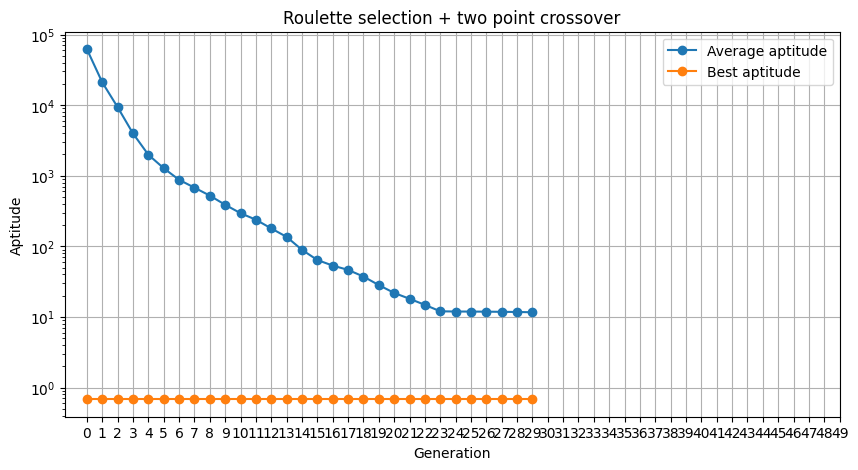

In [8]:
generations = 50

population_x1 = init_octal_population(100, 10)
population_x2 = init_octal_population(100, 10)

last_avg_aptitude = float("inf")
max_stagnant_generations = 5
stagnant_generations = 0
delta = 0.25

avg_aptitudes = []
best_aptitudes = []
evolution = []

for _ in tqdm(range(generations), desc="Generation"):
    population_x1, population_x2, aptitudes, avg_aptitude, best_aptitude = evaluate_population(population_x1, population_x2)
    avg_aptitudes.append(avg_aptitude)
    best_aptitudes.append(best_aptitude)
    evolution.append([population_x1, population_x2, best_aptitude, avg_aptitude])

    if abs(avg_aptitude - last_avg_aptitude) < delta:
        stagnant_generations += 1
        if stagnant_generations > max_stagnant_generations:
            break
    else:
        stagnant_generations = 0

    last_avg_aptitude = avg_aptitude
    parents = roulette_selection(aptitudes)
    childrens_x1 = two_point_crossover(population_x1, parents)
    childrens_x2 = two_point_crossover(population_x2, parents)
    childrens_x1, childrens_x2 = scramble_mutation(childrens_x1, childrens_x2)
    population_x1, population_x2 = genetic_competence(population_x1, population_x2, childrens_x1, childrens_x2)

print(f"Best individue: {decode_individue(evolution[-1][0][0])}, {decode_individue(evolution[-1][1][0])}")
print(f"Best aptitude: {evolution[-1][2]}")
print(f"Avg aptitude: {evolution[-1][3]}")

title = "Roulette selection + two point crossover"
plot_aptitude(avg_aptitudes, best_aptitudes, generations, title)


In [9]:
filename = plot_evolution(evolution, title)
HTML(f'<img src="{filename}">')


MovieWriter ffmpeg unavailable; using Pillow instead.


## Additional 1

Generation:  88%|████████▊ | 44/50 [00:00<00:00, 83.63it/s]


Best individue: 1.4442588029841508, 2.208322349198463
Best aptitude: 1.696493308279284
Avg aptitude: 2.6708626900147205


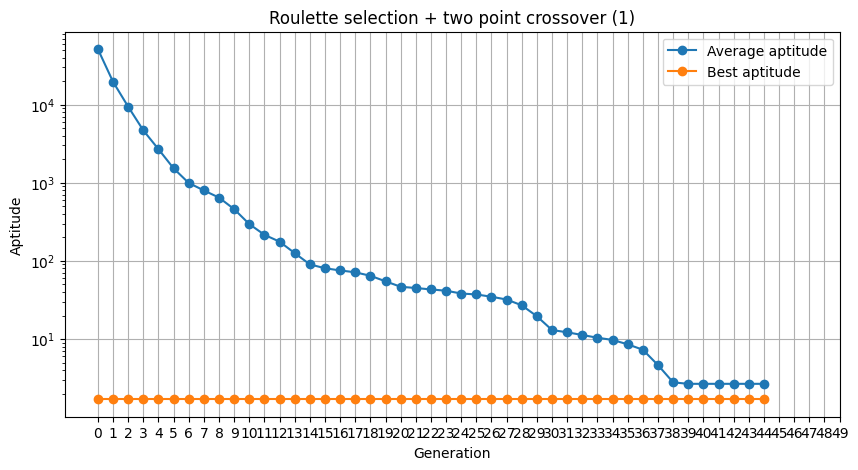

In [10]:
generations = 50

population_x1 = init_octal_population(100, 10)
population_x2 = init_octal_population(100, 10)

last_avg_aptitude = float("inf")
max_stagnant_generations = 5
stagnant_generations = 0
delta = 0.25

avg_aptitudes = []
best_aptitudes = []
evolution = []

for _ in tqdm(range(generations), desc="Generation"):
    population_x1, population_x2, aptitudes, avg_aptitude, best_aptitude = evaluate_population(population_x1, population_x2)
    avg_aptitudes.append(avg_aptitude)
    best_aptitudes.append(best_aptitude)
    evolution.append([population_x1, population_x2, best_aptitude, avg_aptitude])

    if abs(avg_aptitude - last_avg_aptitude) < delta:
        stagnant_generations += 1
        if stagnant_generations > max_stagnant_generations:
            break
    else:
        stagnant_generations = 0

    last_avg_aptitude = avg_aptitude
    parents = roulette_selection(aptitudes)
    childrens_x1 = two_point_crossover(population_x1, parents)
    childrens_x2 = two_point_crossover(population_x2, parents)
    childrens_x1, childrens_x2 = scramble_mutation(childrens_x1, childrens_x2)
    population_x1, population_x2 = genetic_competence(population_x1, population_x2, childrens_x1, childrens_x2)

print(f"Best individue: {decode_individue(evolution[-1][0][0])}, {decode_individue(evolution[-1][1][0])}")
print(f"Best aptitude: {evolution[-1][2]}")
print(f"Avg aptitude: {evolution[-1][3]}")

title = "Roulette selection + two point crossover (1)"
plot_aptitude(avg_aptitudes, best_aptitudes, generations, title)


In [11]:
filename_1 = plot_evolution(evolution, title)
HTML(f'<img src="{filename_1}">')


MovieWriter ffmpeg unavailable; using Pillow instead.


## Additional 2

Generation: 100%|██████████| 50/50 [00:00<00:00, 80.14it/s]


Best individue: 1.1799839615635426, 1.4487521317310188
Best aptitude: 0.35037723548933897
Avg aptitude: 1.1389894169417498


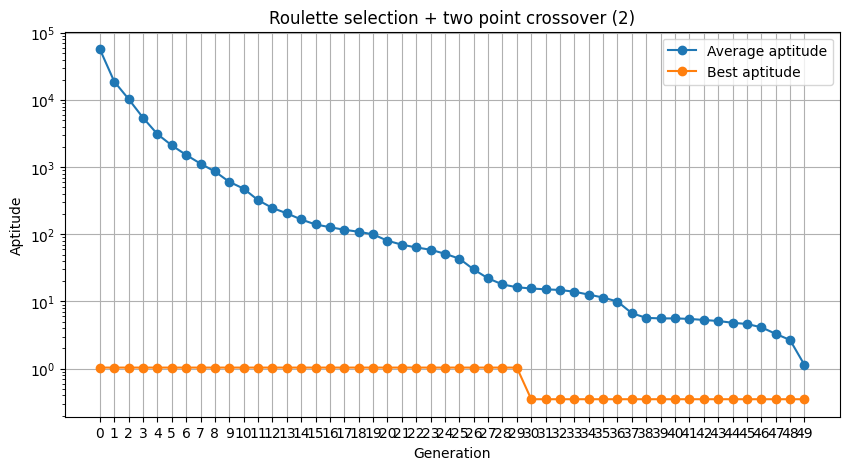

In [12]:
generations = 50

population_x1 = init_octal_population(100, 10)
population_x2 = init_octal_population(100, 10)

last_avg_aptitude = float("inf")
max_stagnant_generations = 5
stagnant_generations = 0
delta = 0.25

avg_aptitudes = []
best_aptitudes = []
evolution = []

for _ in tqdm(range(generations), desc="Generation"):
    population_x1, population_x2, aptitudes, avg_aptitude, best_aptitude = evaluate_population(population_x1, population_x2)
    avg_aptitudes.append(avg_aptitude)
    best_aptitudes.append(best_aptitude)
    evolution.append([population_x1, population_x2, best_aptitude, avg_aptitude])

    if abs(avg_aptitude - last_avg_aptitude) < delta:
        stagnant_generations += 1
        if stagnant_generations > max_stagnant_generations:
            break
    else:
        stagnant_generations = 0

    last_avg_aptitude = avg_aptitude
    parents = roulette_selection(aptitudes)
    childrens_x1 = two_point_crossover(population_x1, parents)
    childrens_x2 = two_point_crossover(population_x2, parents)
    childrens_x1, childrens_x2 = scramble_mutation(childrens_x1, childrens_x2)
    population_x1, population_x2 = genetic_competence(population_x1, population_x2, childrens_x1, childrens_x2)

print(f"Best individue: {decode_individue(evolution[-1][0][0])}, {decode_individue(evolution[-1][1][0])}")
print(f"Best aptitude: {evolution[-1][2]}")
print(f"Avg aptitude: {evolution[-1][3]}")

title = "Roulette selection + two point crossover (2)"
plot_aptitude(avg_aptitudes, best_aptitudes, generations, title)


In [13]:
filename_2 = plot_evolution(evolution, title)
HTML(f'<img src="{filename_2}">')


MovieWriter ffmpeg unavailable; using Pillow instead.
